In [2]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil

In [3]:
gpus = tf.config.experimental.list_logical_devices('GPU')

In [4]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
image_size = 256
batch_size = 32
epochs = 50

In [6]:
data_folder = 'data\data1\Pepper'
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    f"{data_folder}",
    shuffle=True,
    image_size=(image_size,image_size),
    batch_size=batch_size,
)

Found 2475 files belonging to 2 classes.


In [7]:
class_names = dataset.class_names
num_classes = len(class_names)
class_names

['Pepper_bell_Bacterial_spot', 'Pepper_bell_healthy']

In [8]:
len(dataset)

78

(32, 256, 256, 3)
[1 0 0 0 0 1 1 1 0 0 1 1 0 0 1 0 1 1 1 0 1 1 1 0 1 1 1 1 1 1 0 1]


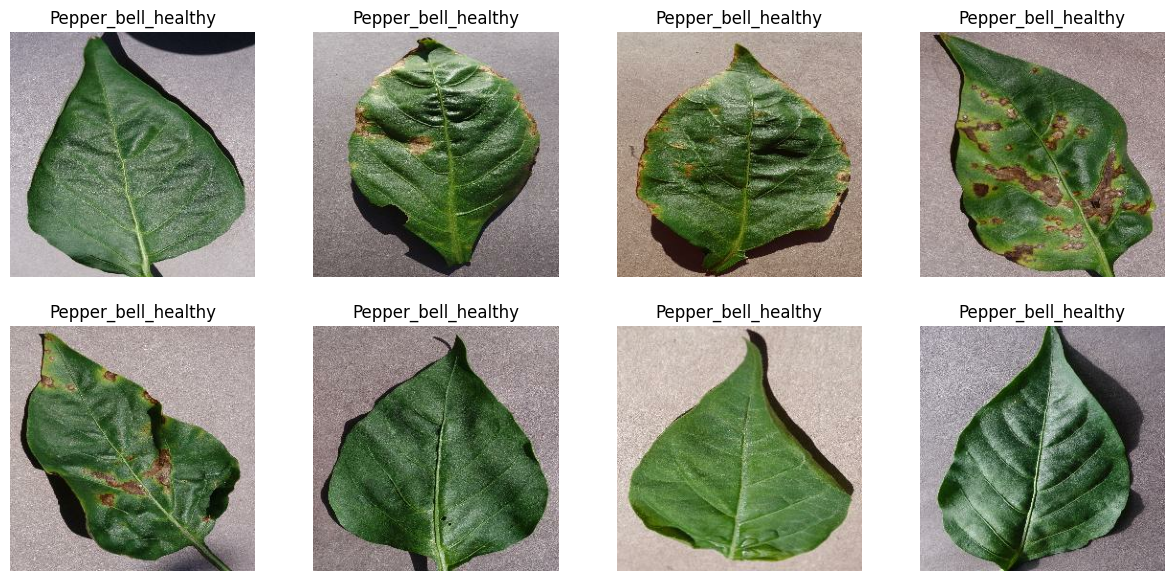

In [9]:
plt.figure(figsize=(15,7))
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())
    for i in range(8):
        ax = plt.subplot(2,4,i+1)
        plt.imshow(image_batch[i].numpy().astype(int)) 
        plt.axis('off')
        plt.title(class_names[label_batch[0]])

In [10]:
def dataset_partition(dataset, train_split=0.8, val_split=0.1, test_plit=0.1, shuffle=True, shuffle_size=10000):
    data_size = len(dataset)

    # Shuffle if True
    if shuffle:
        dataset.shuffle(shuffle_size, seed=0)
    
    # Train and Validation size
    train_size = int(train_split*data_size)
    val_size = int(val_split*data_size)
    
    # Take dataset
    train = dataset.take(train_size)
    val = dataset.skip(train_size).take(val_size)
    test = dataset.skip(train_size).skip(val_size)

    return train, val, test

In [11]:
train, val, test = dataset_partition(dataset)

In [12]:
print(len(train), len(val), len(test))
print(train)

62 7 9
<TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [13]:
train = train.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val = val.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test = test.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE) 

In [14]:
from tensorflow.keras import layers, models

In [15]:
# Data preprocessing
data_preprocess = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(image_size,image_size),
    layers.experimental.preprocessing.Rescaling(1.0/255),

])

# Data augmentation
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [16]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D

In [17]:
from tensorflow.keras import optimizers 
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping

# Set up compile
opt_adam = optimizers.Adam(learning_rate=0.0001, decay=1e-6)
metric = 'accuracy'
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)

#Callback
logdir = 'logs'
tensorboard_callback = TensorBoard(log_dir=logdir)
earlystop_callback = EarlyStopping(monitor='val_loss', patience=5)

In [18]:
def plot_loss_accuracy(hist):
    # Plot performance of model
    fig = plt.figure(figsize=(10,5))
    ax = plt.subplot(1,2,1)
    plt.plot(hist.history['loss'], color='orange', label='loss')
    plt.plot(hist.history['val_loss'], color='teal', label='val loss')


    ax = plt.subplot(1,2,2)
    plt.plot(hist.history['accuracy'], color='orange', label='accuracy')
    plt.plot(hist.history['val_accuracy'], color='teal', label='val accuracy')


    return None

In [19]:
# Save model with updated version
os.makedirs("models", exist_ok=True)
def save_model(model):
    model_ver = max([int(i) for i in os.listdir("models/pepper")]+[0]) + 1
    model.save(f"models/pepper/{model_ver}")
    return None

In [20]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D

input_shape = (batch_size, image_size, image_size, 3)

# Build CNN model

model = models.Sequential([
    data_preprocess,
    data_augmentation,
    
    Conv2D(32, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2,2)),

    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2,2)),

    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2,2)),

    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2,2)),

    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2,2)),

    Flatten(),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax'),

])

model.build(input_shape=input_shape)

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 batch_normalization (BatchN  (32, 254, 254, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)       

In [21]:
model.compile(
    optimizer=opt_adam,
    loss=loss,
    metrics=[metric],
)

In [26]:
hist = model.fit(
    train,
    epochs=epochs,
    batch_size=batch_size,
    verbose=1,
    validation_data=val,
    shuffle=True,
    callbacks=[tensorboard_callback]
)

Epoch 1/50
62/62 [==============================] - 30s 258ms/step - loss: 0.3897 - accuracy: 0.8412 - val_loss: 0.7333 - val_accuracy: 0.5804
Epoch 2/50
62/62 [==============================] - 7s 106ms/step - loss: 0.2320 - accuracy: 0.9158 - val_loss: 0.9983 - val_accuracy: 0.5804
Epoch 3/50
62/62 [==============================] - 6s 103ms/step - loss: 0.1780 - accuracy: 0.9325 - val_loss: 1.2186 - val_accuracy: 0.5804
Epoch 4/50
62/62 [==============================] - 6s 103ms/step - loss: 0.1383 - accuracy: 0.9501 - val_loss: 0.8688 - val_accuracy: 0.5848
Epoch 5/50
62/62 [==============================] - 6s 103ms/step - loss: 0.1052 - accuracy: 0.9703 - val_loss: 0.6054 - val_accuracy: 0.7232
Epoch 6/50
62/62 [==============================] - 6s 103ms/step - loss: 0.0868 - accuracy: 0.9693 - val_loss: 0.3448 - val_accuracy: 0.8214
Epoch 7/50
62/62 [==============================] - 6s 103ms/step - loss: 0.0779 - accuracy: 0.9778 - val_loss: 0.3180 - val_accuracy: 0.8482
Epoch

9/9 [==============================] - 3s 130ms/step - loss: 0.0322 - accuracy: 0.9850


[0.032168198376894, 0.9850187301635742]

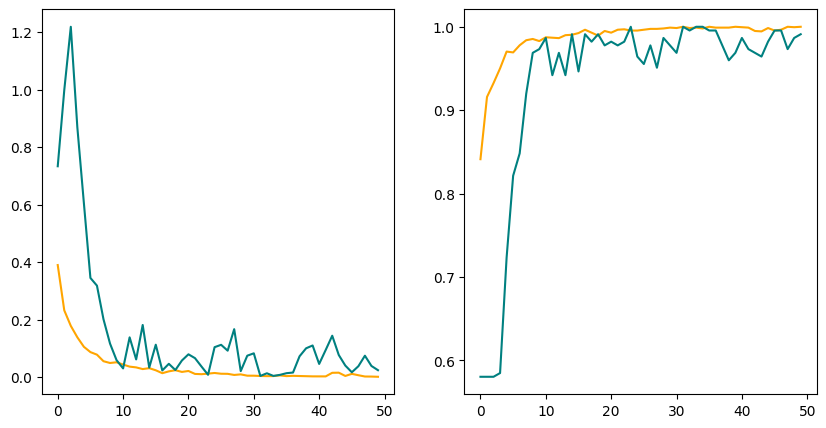

In [27]:
plot_loss_accuracy(hist)
scores = model.evaluate(test)
scores

In [32]:
save_model(model)

INFO:tensorflow:Assets written to: models/pepper/1\assets



    Actual label: Pepper_bell_Bacterial_spot
    Predict label: Pepper_bell_Bacterial_spot
    


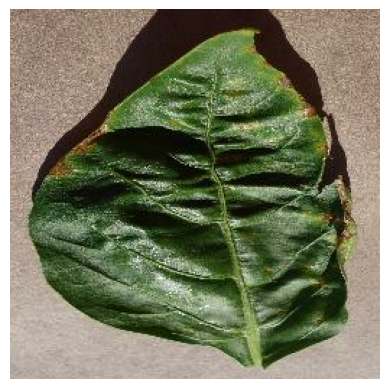

In [35]:
for image_batch, label_batch in test.take(1):
    first_image = image_batch[0].numpy().astype(int)
    first_label = class_names[label_batch[0].numpy()]
    prediction_batch = model.predict(image_batch)
    predict_label = class_names[np.argmax(prediction_batch[0])]
    print(f'''
    Actual label: {first_label}
    Predict label: {predict_label}
    ''')
    plt.imshow(first_image)
    plt.axis('off')

In [36]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img.numpy())
    img_array = tf.expand_dims(img_array, 0) #Create a batch

    predictions = model.predict(img_array)

    predict_label = class_names[np.argmax(predictions[0])]
    confidence = round(100*(np.max(predictions[0])),2)

    return predict_label, confidence

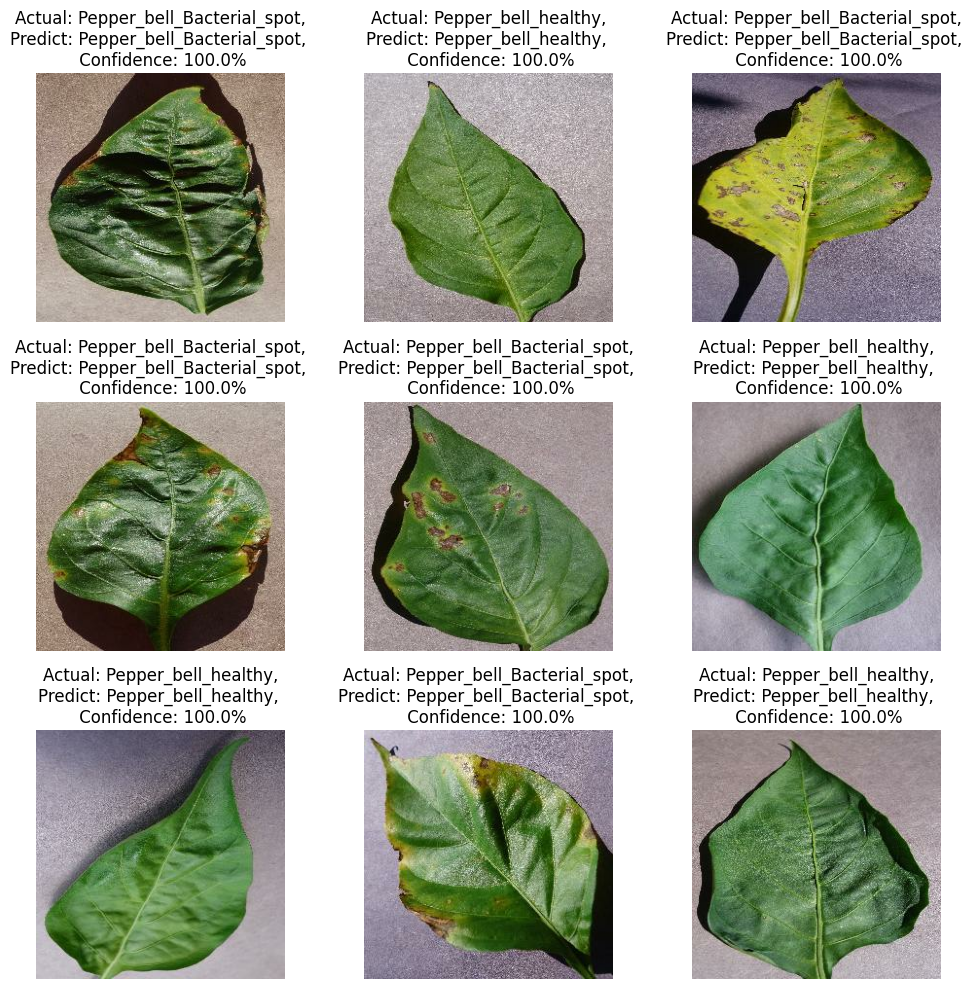

In [39]:
is_break = False
while not is_break:
    for images, labels in test.take(1):
        num_img = 9
        if len(images)>=num_img:
            is_break = True
            fig = plt.figure(figsize=(10,10))
            for i in range(num_img):
                ax = plt.subplot(3,3,i+1)
                predict_label, confidence = predict(model, images[i])
                actual_label = class_names[labels[i]]
                plt.imshow(images[i].numpy().astype(int))
                plt.title(f'Actual: {actual_label},\nPredict: {predict_label}, \n Confidence: {confidence}%', fontsize=12)
                plt.axis('off')
            fig.tight_layout()

In [25]:
model_trans = tf.keras.models.load_model("models/potato/3")

In [ ]:
for image_batch, label_batch in test.take(1):
    first_image = image_batch[0].numpy().astype(int)
    first_label = class_names[label_batch[0].numpy()]
    prediction_batch = model_trans.predict(image_batch)
    predict_label = class_names[np.argmax(prediction_batch[0])]
    print(f'''
    Actual label: {first_label}
    Predict label: {predict_label}
    ''')
    plt.imshow(first_image)
    plt.axis('off')